In [1]:
import sys
import os
sys.path.append(os.path.abspath('../'))
import torch
from matplotlib import pyplot as plt
from data import PVDataGenerator, PVDataLoader
from data.utils import (cross_val_fold, 
                        train_test_split_fold,
                        train_test_split)
from pv_plot import plot_train_test_split, plot_seasons
from hypertuning import MultitaskBetaQPGP

In [16]:
# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 365
N_DAYS_TRAIN = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 40
RADIUS = 0.35
CIRCLE_COORDS = (55, -1.5)


In [17]:
generator = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    coords=CIRCLE_COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv',
                    distance_method='circle',
                    season='spring',
                    drop_nan=False)

X, y = generator.get_time_series()

==> Loading data
==> Loaded data in: 0 m : 6 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [25]:
# randomly select 15 systems
import numpy as np
index = np.random.choice(np.arange(0, y.size(-1), 1), size=15, replace=False)
y = y[:int(DAILY_DATA_POINTS*30), index]
X = X[:int(DAILY_DATA_POINTS*30)]

In [26]:
y.shape

torch.Size([2880, 15])

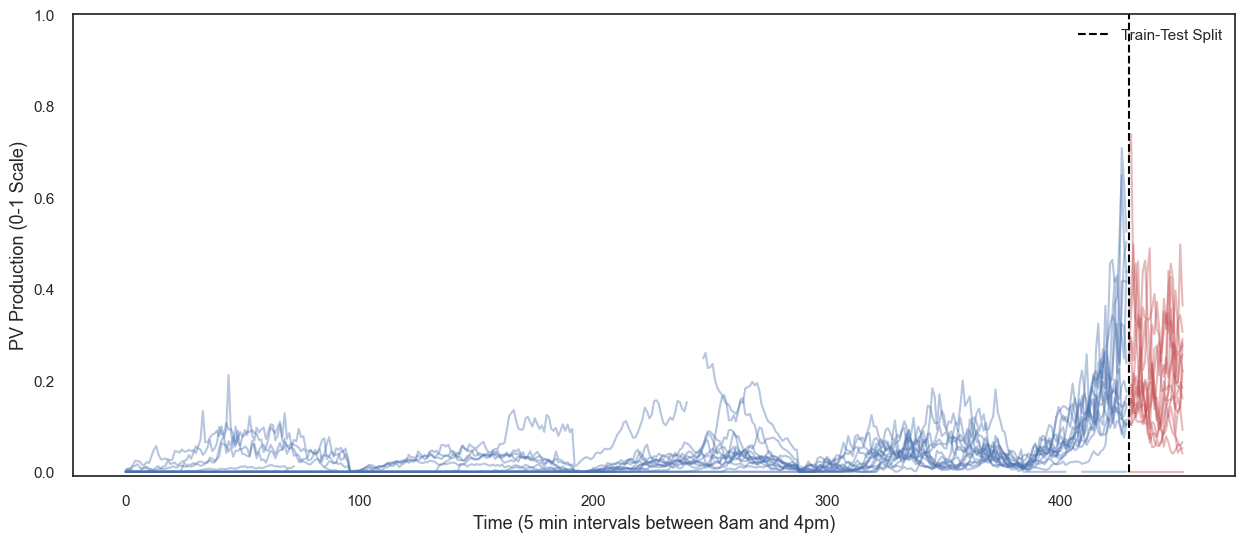

In [27]:
# checking if periodicity is correlated across outputs
x_train, y_train, x_test, y_test = train_test_split(X[:500], y[:500], hour=12)
plot_train_test_split(y_train, y_test)

In [28]:
x_list, y_list = cross_val_fold(X, y, N_DAYS_TRAIN, DAILY_DATA_POINTS)
x_train, y_train, x_test, y_test =  train_test_split_fold(x_list, y_list, N_HOURS_PRED, MINUTE_INTERVAL, DAY_MIN, DAY_MAX)

In [29]:
train_loader = PVDataLoader(x_train, y_train)
test_loader = PVDataLoader(x_test, y_test)

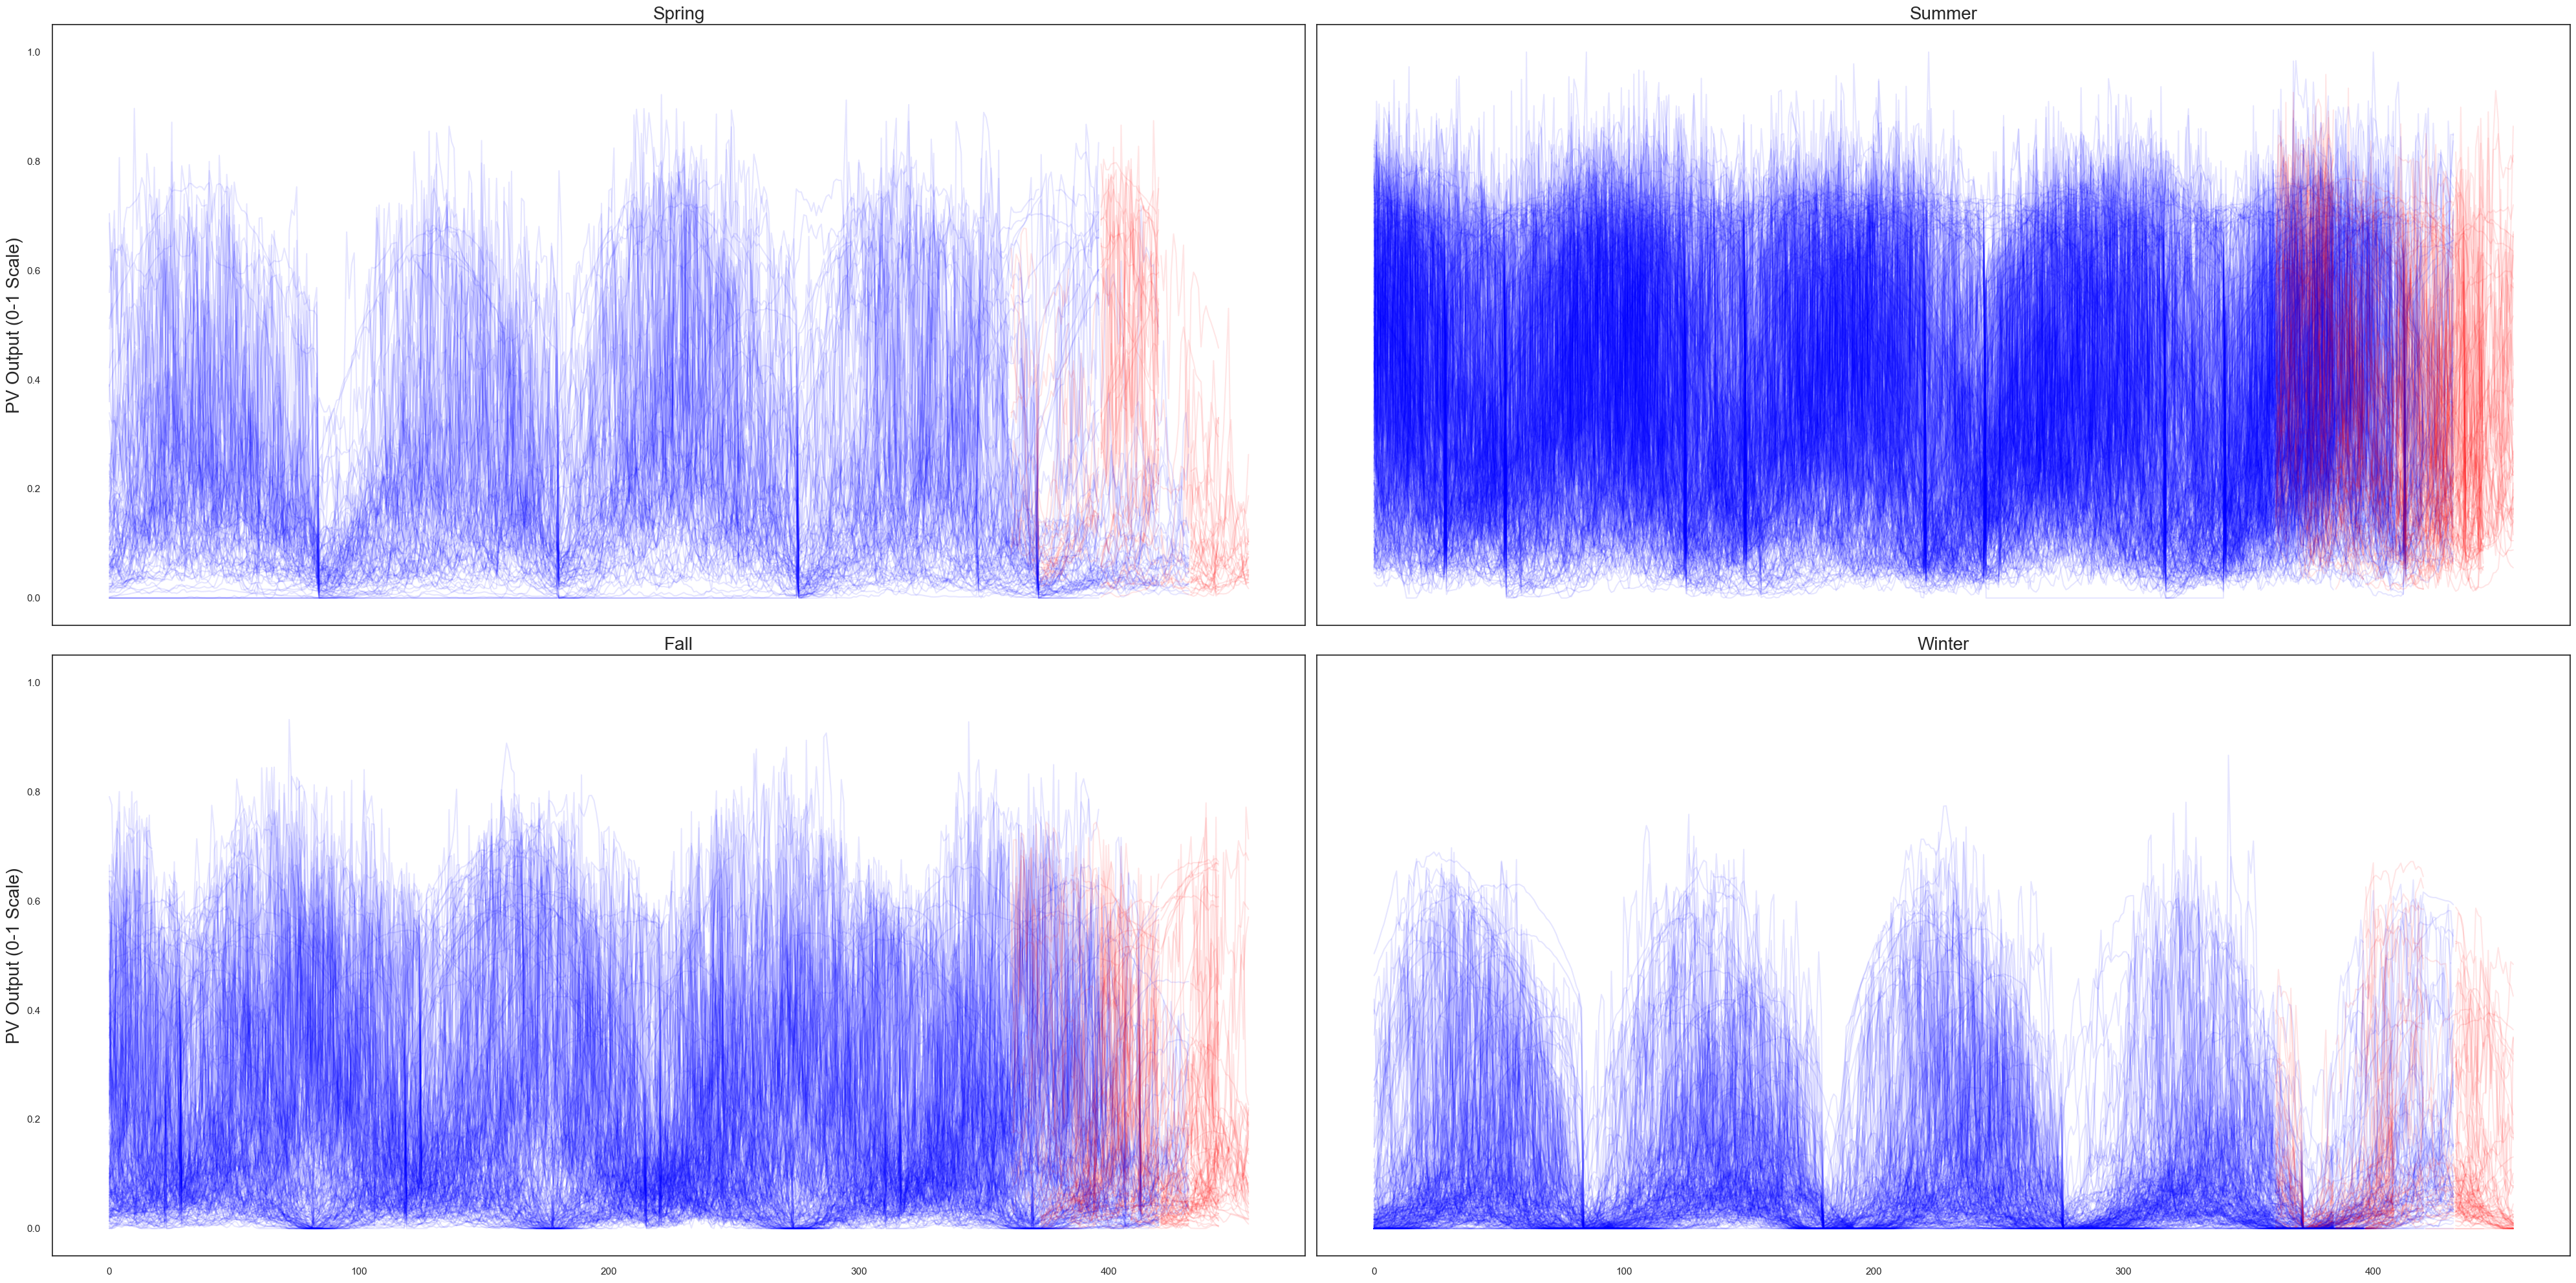

In [14]:
plot_seasons(
    train_loader_sp=train_loader_sp,
    test_loader_sp=test_loader_sp,
    train_loader_su=train_loader_su,
    test_loader_su=test_loader_su,
    train_loader_f=train_loader_f,
    test_loader_f=test_loader_f,
    train_loader_w=train_loader_w,
    test_loader_w=test_loader_w,
)

In [30]:
model = MultitaskBetaQPGP(train_loader=train_loader,
                          test_loader=test_loader)

In [31]:
model.run_study(n_trials=100, direction='minimize')

[I 2023-08-08 11:59:33,140] A new study created in memory with name: no-name-0ef95f1a-7816-4090-bee4-98655c0dbff9


Percentage inside 95% CI: 100.00%
Percentage inside 95% CI: 100.00%
Percentage inside 95% CI: 100.00%
Percentage inside 95% CI: 100.00%
Percentage inside 95% CI: 100.00%
Percentage inside 95% CI: 95.83%
Percentage inside 95% CI: 100.00%
Percentage inside 95% CI: 100.00%
Percentage inside 95% CI: 100.00%
Percentage inside 95% CI: 100.00%
Percentage inside 95% CI: 95.83%
Percentage inside 95% CI: 100.00%
Percentage inside 95% CI: 100.00%
Percentage inside 95% CI: 100.00%
Percentage inside 95% CI: 100.00%
Percentage inside 95% CI: 91.67%
Percentage inside 95% CI: 87.50%
Percentage inside 95% CI: 100.00%
Percentage inside 95% CI: 50.00%
Percentage inside 95% CI: 100.00%
Percentage inside 95% CI: 100.00%
Percentage inside 95% CI: 75.00%
Percentage inside 95% CI: 100.00%
Percentage inside 95% CI: 91.67%
Percentage inside 95% CI: 95.83%
Percentage inside 95% CI: 12.50%
Percentage inside 95% CI: 95.83%
Percentage inside 95% CI: 100.00%
Percentage inside 95% CI: 66.67%
Percentage inside 95% CI:

[W 2023-08-08 12:04:11,290] Trial 0 failed with parameters: {'num_latents': 2, 'scale_init': 1, 'mean': 'constant', 'lr * 100': 20, 'epochs': 500} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/Users/eirikbaekkelund/Desktop/UCL/Code/Dissertation/hypertuning/multitask.py", line 68, in objective
    self.instantiate_model()
  File "/Users/eirikbaekkelund/Desktop/UCL/Code/Dissertation/hypertuning/multitask.py", line 27, in instantiate_model
    self.model.fit(**self.train_config, verbose=False)
  File "/Users/eirikbaekkelund/Desktop/UCL/Code/Dissertation/models/multitask.py", line 92, in fit
    loss.backward()
  File "/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/torch/_tensor.py", line 487, in backward
    torch

KeyboardInterrupt: 

In [ ]:
model.study.best_params

{'num_latents': 3,
 'scale_init': 11,
 'mean': 'zero',
 'lr * 100': 10,
 'epochs': 800}